In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from sklearn import metrics
from scipy import stats, spatial
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

ee.Initialize()

%load_ext autoreload
%autoreload 2

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numba/core/decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# The math


#### Entropy: 

Given a discrete random variable $X$, with possible outcomes $ x_{1},...,x_{n} $ which occur with probability $  \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n}) $ the entropy (units of nats) of $X$ is defined as: <br>

$ H(X) =  - \sum_{i=1}^{n} P(x) \ln P(x) $

#### Joint Entropy:
of two discrete random variables $X$ and $Y$ is defined as the entropy of the joint distribution of $X$ and $Y$:

$ H(X,Y) =  - \sum_{i=1}^{n} P(x,y) \ln P(x,y) $


#### Conditional Entropy: 

The amount of information needed to describe the outcome of a random variable $Y$ given that the value of another random variable $X$ is known. Here, information is measured in shannons, nats, or hartleys. The entropy of $Y$ conditioned on $X$ is:

$ H (Y|X) = -\sum p(x,y)\ln {\frac {p(x,y)}{p(x)}} $


#### Relative Entropy, aka K-L Divergence,

The Relative Entropy (aka K-L divergence, $ D_{\text{KL}}(P\parallel Q)$ ), which measures how one probability distribution $P(x)$ is different from a second $Q(x)$ is defined as:

$ D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\ln \left({\frac {P(x)}{Q(x)}}\right)$

#### Jensen Shannon Distance:

The Jensen Shannon Distance (JSD) also measures how one probability distribution $P(x)$ is different from a second $Q(x)$, but has desirable properties of always being finite and symmetric: 

$ JSD(X) = \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}\$

where $D(x \parallel y)$ is the K-L Divergence, defined above.


#### Mutual information

measures how much information can be obtained about one random variable by observing another. The mutual information of $X$ relative to $Y$ (which represents conceptually the average amount of information about $X$ that can be gained by observing $Y$ is given by:

$ I(X; Y)=H(X)− H(X|Y)= -\sum p(x,y)\ln \frac{p(x,y)}{p(x) p(y)} $

We will use $H(x)$ and $JSD(x)$ with P(x) as the 2003 - 2020 P, SWE, and dSWE/dt and Q(x) as reservoir inflow. 


In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - daily SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return indf

def calc_pstack_entropy(pstack):
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = pstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = pstack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    outim = np.zeros_like(np.mean(pstack, axis = 2))

    # Compute and compile the transfer entropies 
    outict = {}

    # Loop through the cols, calc entropy
    nbins = calc_nbins(len(pxdf))
    print("Bins = {}".format(nbins))
    for pxidx in tqdm(pxdf.columns[:]):

        vals = pd.Series(pxdf[[pxidx]].values.reshape(pxdf[[pxidx]].values.shape[0])).value_counts(normalize=True, bins = nbins)
        outict[pxidx] = [stats.entropy(vals)]

    outdf = pd.DataFrame.from_dict(outict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
    
    return outim

def calc_swestack_entropy(swestack, dswe = False):

    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)
    # if time derivative, we have to ditch the first date 
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Build the out image
    outim = np.zeros_like(np.mean(swestack, axis = 2))

    # Compute and compile the transfer entropies 
    outict = {}

    # Loop through the cols, calc entropy
    nbins = calc_nbins(len(pxdf))
    for pxidx in tqdm(pxdf.columns[:]):

        vals = pd.Series(pxdf[[pxidx]].values.reshape(pxdf[[pxidx]].values.shape[0])).value_counts(normalize=True, bins = nbins)
        outict[pxidx] = [stats.entropy(vals)]

    outdf = pd.DataFrame.from_dict(outict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val

    return outim

def dict2im(outdict, empty_im, rclist=None):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim


def calc_nbins(N):
    
    
    '''
    A. Hacine-Gharbi, P. Ravier, "Low bias histogram-based estimation of mutual information for feature selection", Pattern Recognit. Lett (2012).
    '''
    ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
    bins = np.round(ee/6 + 2/(3*ee) + 1/3)

    return int(bins)

def calc_mi_bins(swestack, dswe = False, inflow = None):
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')

    rows, cols, time = swestack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = swestack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)

    # if time derivative, we have to ditch the first date 
    pxdf.columns = pxdf.columns.map(str)
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Filter infs
    pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Drop nans, infs, etc 
    kldf = mdf[mdf['q_cms'].notna()]
    kldf = kldf[~kldf.isin([np.nan, np.inf, -np.inf]).any(1)]
    target = kldf['q_cms']
    kldf.drop(['q_cms'], axis =1 , inplace = True)

    # Build the out image
    outim = np.zeros_like(np.mean(swestack, axis = 2))

    # get n bins
    nbins = calc_nbins(len(kldf))
    print("Bins = {}".format(nbins))

    # Setup out dicts to store calcs 
    mi5_dict = {}
    mi10_dict = {}
    mi15_dict = {}
    mi25_dict = {}
    mi50_dict = {}


    # Loop through the cols, calc stuff 
    for pxidx in tqdm(kldf.columns[:]):

        vals = pd.Series(kldf[[pxidx]].values.reshape(kldf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
        vals[~np.isfinite(vals)] = 0
        tempdf = pd.DataFrame([vals,target.values]).T
        tempdf.columns = ['swe','q_cms']
        mi5 = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 5),tempdf['q_cms'].value_counts(normalize=True,bins = 5))
        mi10 = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 10),tempdf['q_cms'].value_counts(normalize=True,bins = 10))
        mi15 = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 15),tempdf['q_cms'].value_counts(normalize=True,bins = 15))
        mi25 = metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 25),tempdf['q_cms'].value_counts(normalize=True,bins = 25))
        mi50 =metrics.mutual_info_score(tempdf['swe'].value_counts(normalize=True,bins = 50),tempdf['q_cms'].value_counts(normalize=True,bins = 50))

        mi5_dict[pxidx] = [mi5]
        mi10_dict[pxidx] = [mi10]
        mi15_dict[pxidx] = [mi15]
        mi25_dict[pxidx] = [mi25]
        mi50_dict[pxidx] = [mi50]


    mi5_im = dict2im(mi5_dict, outim, rclist = rclist)
    mi5_im[mi5_im == 0] = np.nan
    mi10_im = dict2im(mi10_dict, outim, rclist = rclist)
    mi10_im[mi10_im==0] = np.nan
    mi15_im = dict2im(mi15_dict, outim, rclist = rclist)
    mi15_im[mi15_im == 0] = np.nan
    mi25_im = dict2im(mi25_dict, outim, rclist = rclist)
    mi25_im[mi25_im == 0] = np.nan
    mi50_im = dict2im(mi50_dict, outim, rclist = rclist)
    mi50_im[mi50_im == 0] = np.nan

    return mi5_im, mi10_im, mi15_im, mi25_im, mi50_im

def plot_mean_ims(p_mean,swe_mean,dswe_mean,  stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("mean P")
    im = ax1.imshow(p_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("mean SWE")
    im2 = ax2.imshow(swe_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    ax3 = plt.subplot(133)
    ax3.set_title("mean ∆SWE")
    im3 = ax3.imshow(dswe_mean)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_mean.png'.format(stid))
    
    return plt.show()

def plot_ent_ims(p_ent,swe_ent,dswe_ent, stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("H(P)")
    im = ax1.imshow(p_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("H(SWE)")
    im2 = ax2.imshow(swe_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(133)
    ax3.set_title("H(∆SWE)")
    im3 = ax3.imshow(dswe_ent)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_ent.png'.format(stid))

    return plt.show()
    
def plot_mi_bins_ims(mi5_im, mi10_im, mi15_im, mi25_im, mi50_im, stid = None, var = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(151)
    ax1.set_title("{} MI 5 bins".format(var))
    im = ax1.imshow(mi5_im)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(152)
    ax2.set_title("{} MI 10 bins".format(var))
    im2 = ax2.imshow(mi10_im)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(153)
    ax3.set_title("{} MI 15 bins".format(var))
    im3 = ax3.imshow(mi15_im)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    ax4 = plt.subplot(154)
    ax4.set_title("{} MI 25 bins".format(var))
    im4 = ax4.imshow(mi25_im)
    plt.axis('off')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax)
    
    ax5 = plt.subplot(155)
    ax5.set_title("{} MI 50 bins".format(var))
    im5 = ax5.imshow(mi50_im)
    plt.axis('off')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_{}_MI_bins.png'.format(stid,var))

    return plt.show()    


In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '1950-09-30'
enddate = '2020-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

outdir = "../rasters/InfoTheory_NBins"

In [4]:
# Big loop through all catchments to get the data, do the xcorrelation, and write files 

************************************************************
Processing res_id: ENG, in catchment: YUBA R


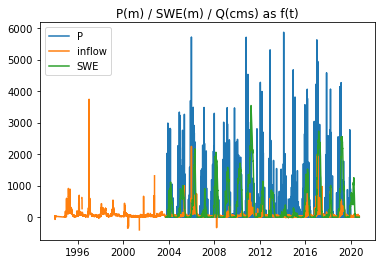

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


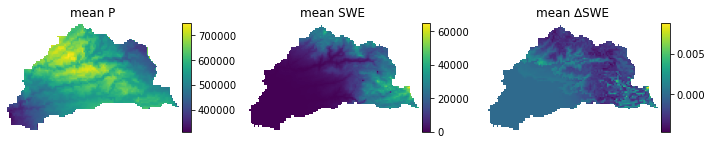

  0%|          | 4/7452 [00:00<03:18, 37.45it/s]

Bins = 27


100%|██████████| 4670/4670 [00:49<00:00, 94.39it/s]


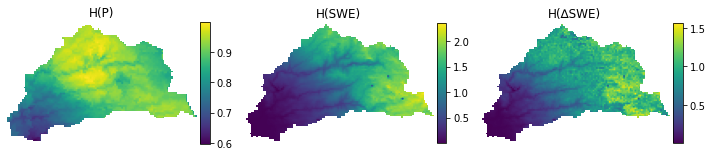

wrote ../rasters/InfoTheory_NBins/ENG_p_ent.tif
wrote ../rasters/InfoTheory_NBins/ENG_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/ENG_dswe_ent.tif


  0%|          | 0/7452 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7452/7452 [34:02<00:00,  3.65it/s]


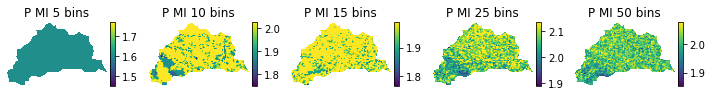

  0%|          | 0/4670 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 4670/4670 [21:27<00:00,  3.63it/s]


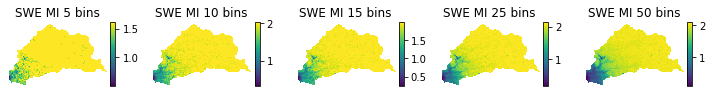

  0%|          | 0/4670 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 4670/4670 [21:26<00:00,  3.63it/s]


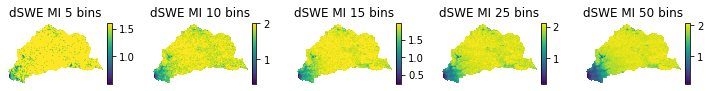

************************************************************
Processing res_id: PAR, in catchment: MOKELUMNE R


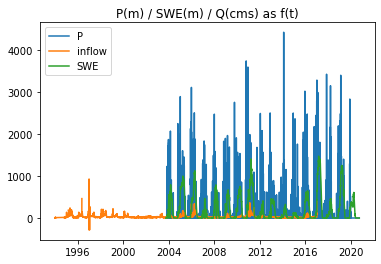

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


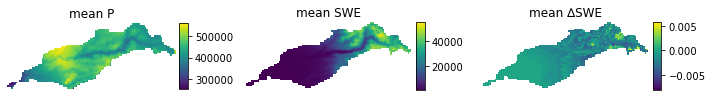

  0%|          | 19/4305 [00:00<00:46, 91.58it/s]

Bins = 27


100%|██████████| 2076/2076 [00:21<00:00, 94.50it/s]


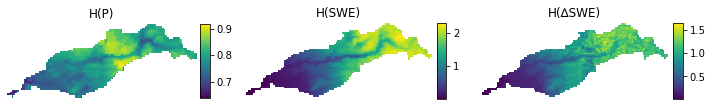

wrote ../rasters/InfoTheory_NBins/PAR_p_ent.tif
wrote ../rasters/InfoTheory_NBins/PAR_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/PAR_dswe_ent.tif


  0%|          | 0/4305 [00:00<?, ?it/s]

Bins = 25


100%|██████████| 4305/4305 [16:56<00:00,  4.24it/s]


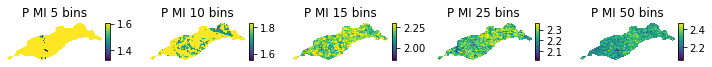

  0%|          | 0/2076 [00:00<?, ?it/s]

Bins = 25


100%|██████████| 2076/2076 [08:10<00:00,  4.23it/s]


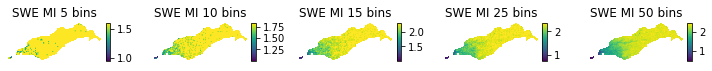

  0%|          | 0/2076 [00:00<?, ?it/s]

Bins = 25


100%|██████████| 2076/2076 [08:11<00:00,  4.23it/s]


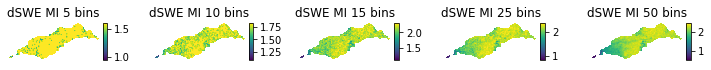

************************************************************
Processing res_id: MIL, in catchment: SAN JOAQUIN R


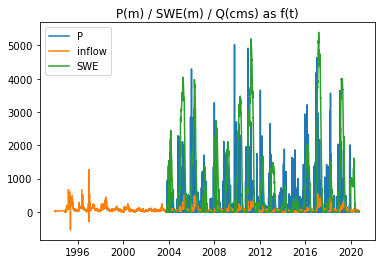

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


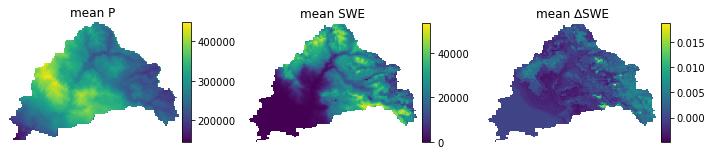

  0%|          | 19/10080 [00:00<01:49, 91.51it/s]

Bins = 27


100%|██████████| 6172/6172 [01:05<00:00, 94.27it/s]


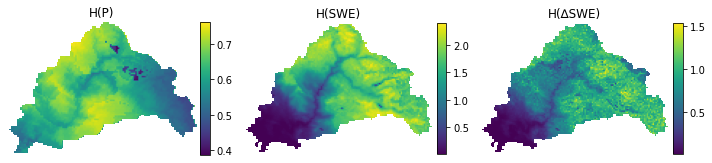

wrote ../rasters/InfoTheory_NBins/MIL_p_ent.tif
wrote ../rasters/InfoTheory_NBins/MIL_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/MIL_dswe_ent.tif


  0%|          | 0/10080 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 10080/10080 [46:31<00:00,  3.61it/s]


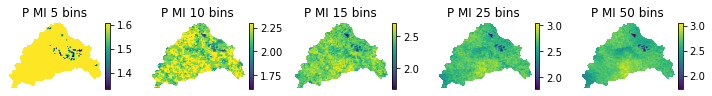

  0%|          | 0/6172 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 6172/6172 [29:50<00:00,  3.45it/s]


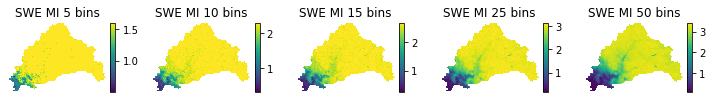

  0%|          | 0/6172 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 6172/6172 [28:31<00:00,  3.61it/s]


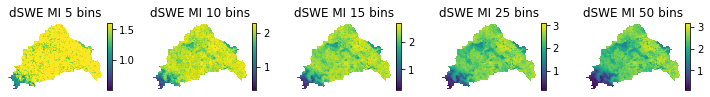

************************************************************
Processing res_id: ISB, in catchment: KERN R


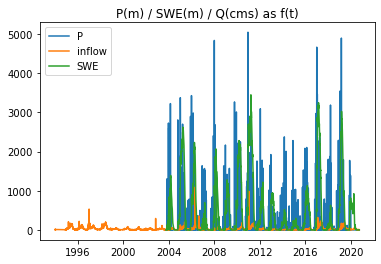

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


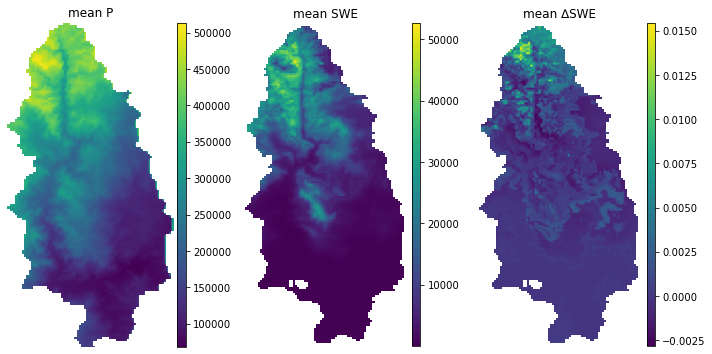

  0%|          | 9/10366 [00:00<01:56, 89.16it/s]

Bins = 27


100%|██████████| 7668/7668 [01:21<00:00, 94.11it/s]


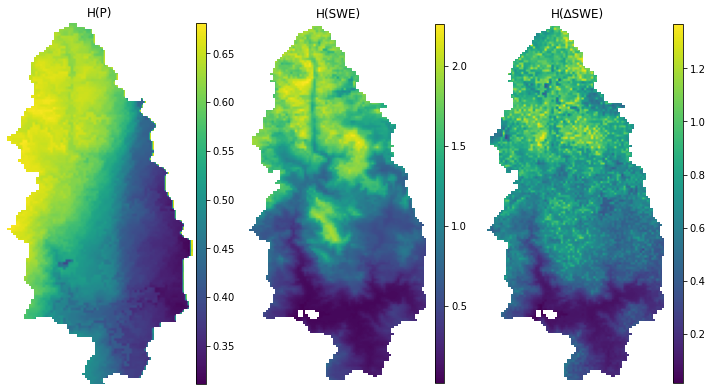

wrote ../rasters/InfoTheory_NBins/ISB_p_ent.tif
wrote ../rasters/InfoTheory_NBins/ISB_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/ISB_dswe_ent.tif


  0%|          | 0/10366 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 10366/10366 [47:31<00:00,  3.64it/s]


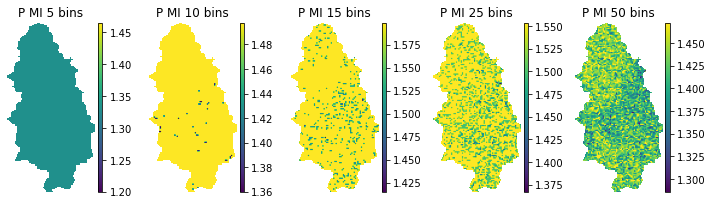

  0%|          | 0/7668 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7668/7668 [35:15<00:00,  3.62it/s]


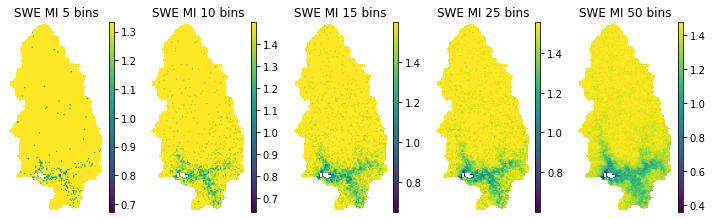

  0%|          | 0/7668 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7668/7668 [35:10<00:00,  3.63it/s]


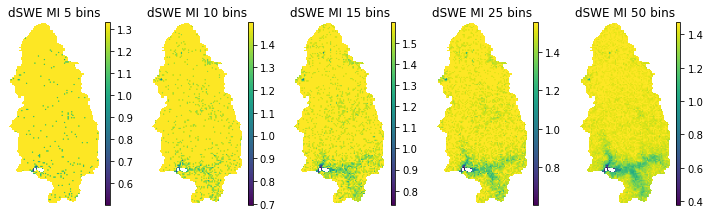

************************************************************
Processing res_id: DNP, in catchment: TUOLUMNE R


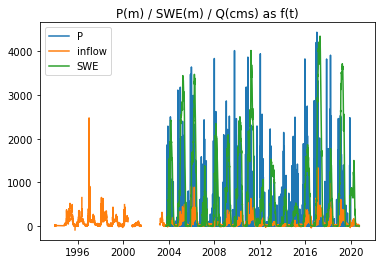

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


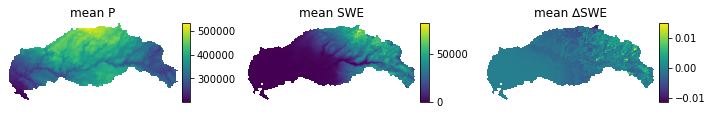

  0%|          | 19/9230 [00:00<01:40, 91.31it/s]

Bins = 27


100%|██████████| 5813/5813 [01:01<00:00, 94.42it/s]


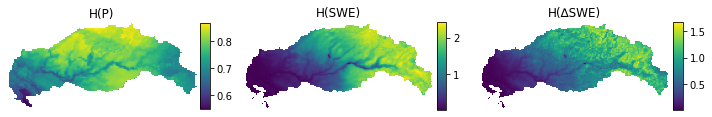

wrote ../rasters/InfoTheory_NBins/DNP_p_ent.tif
wrote ../rasters/InfoTheory_NBins/DNP_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/DNP_dswe_ent.tif


  0%|          | 0/9230 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 9230/9230 [41:42<00:00,  3.69it/s]


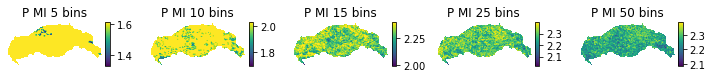

  0%|          | 0/5813 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 5813/5813 [30:00<00:00,  3.23it/s]


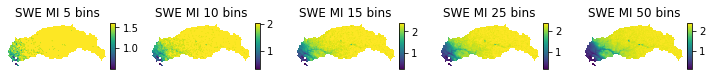

  0%|          | 0/5813 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 5813/5813 [27:03<00:00,  3.58it/s]


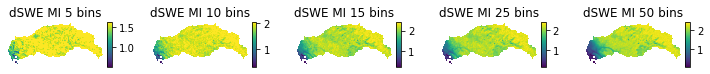

************************************************************
Processing res_id: NML, in catchment: STANISLAUS R


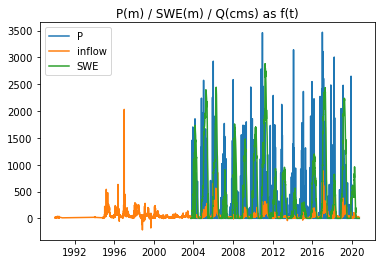

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


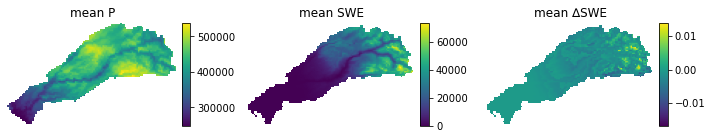

  0%|          | 9/7437 [00:00<01:24, 87.50it/s]

Bins = 27


100%|██████████| 3452/3452 [00:36<00:00, 94.05it/s]


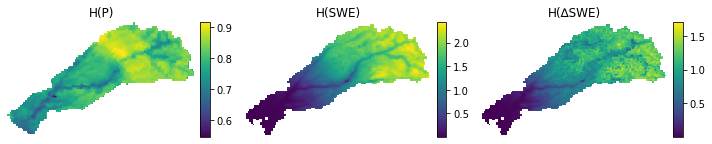

wrote ../rasters/InfoTheory_NBins/NML_p_ent.tif
wrote ../rasters/InfoTheory_NBins/NML_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/NML_dswe_ent.tif


  0%|          | 0/7437 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7437/7437 [34:11<00:00,  3.63it/s]


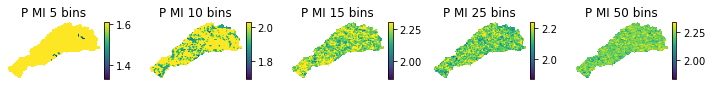

  0%|          | 0/3452 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 3452/3452 [15:54<00:00,  3.62it/s]


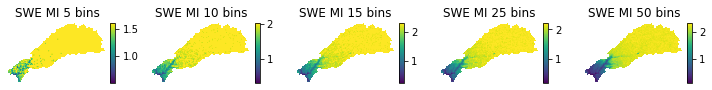

  0%|          | 0/3452 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 3452/3452 [15:59<00:00,  3.60it/s]


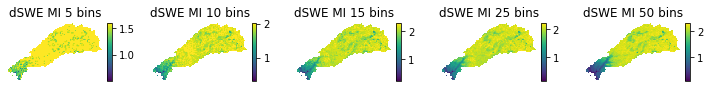

************************************************************
Processing res_id: ORO, in catchment: FEATHER R


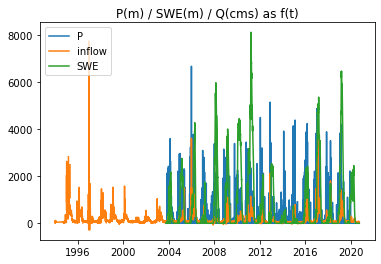

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


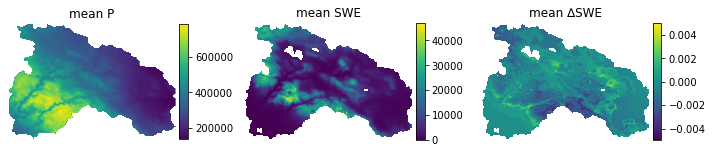

  0%|          | 9/18645 [00:00<03:30, 88.43it/s]

Bins = 27


100%|██████████| 14059/14059 [02:30<00:00, 93.21it/s]


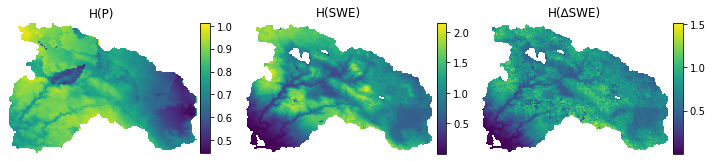

wrote ../rasters/InfoTheory_NBins/ORO_p_ent.tif
wrote ../rasters/InfoTheory_NBins/ORO_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/ORO_dswe_ent.tif


  0%|          | 0/18645 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 18645/18645 [1:27:03<00:00,  3.57it/s]


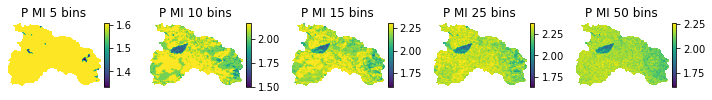

  0%|          | 0/14059 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 14059/14059 [1:05:00<00:00,  3.60it/s]


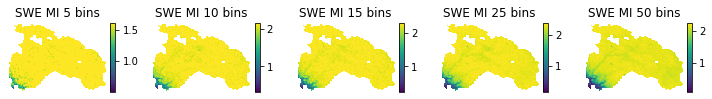

  0%|          | 0/14059 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 14059/14059 [1:05:00<00:00,  3.60it/s]


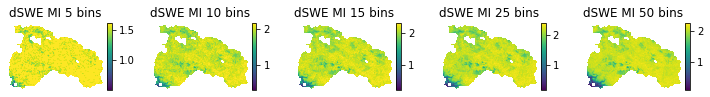

************************************************************
Processing res_id: FOL, in catchment: AMERICAN R


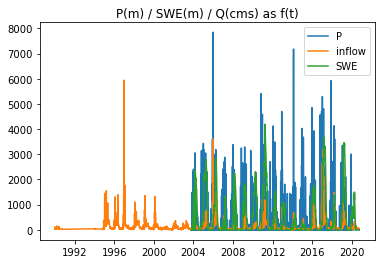

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


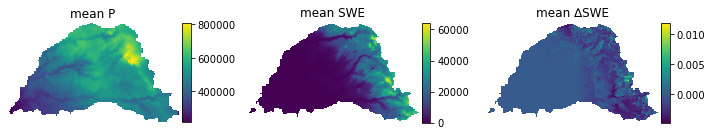

  0%|          | 19/10530 [00:00<01:55, 90.63it/s]

Bins = 27


100%|██████████| 7196/7196 [01:16<00:00, 93.52it/s]


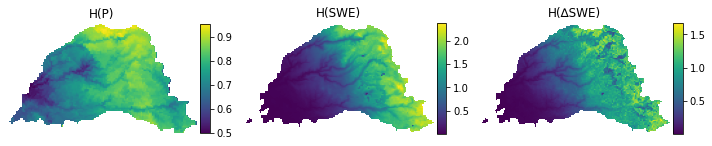

wrote ../rasters/InfoTheory_NBins/FOL_p_ent.tif
wrote ../rasters/InfoTheory_NBins/FOL_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/FOL_dswe_ent.tif


  0%|          | 0/10530 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 10530/10530 [48:23<00:00,  3.63it/s]


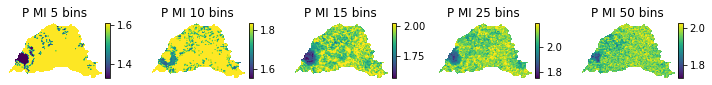

  0%|          | 0/7196 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7196/7196 [33:04<00:00,  3.63it/s]


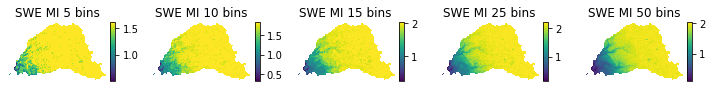

  0%|          | 0/7196 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 7196/7196 [33:15<00:00,  3.61it/s]


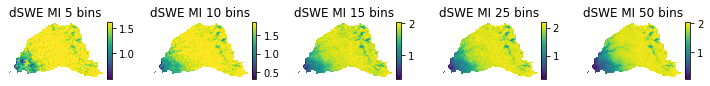

************************************************************
Processing res_id: TRM, in catchment: KAWEAH R


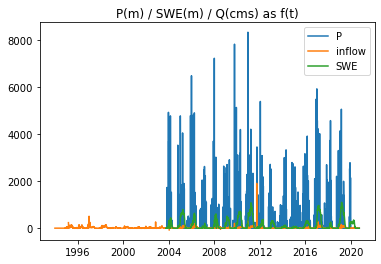

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


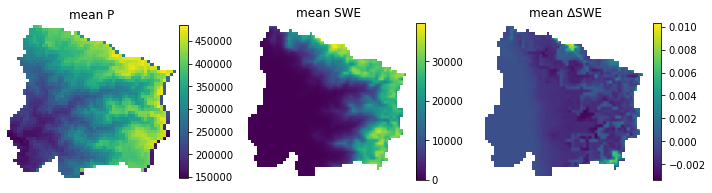

  1%|          | 19/2544 [00:00<00:27, 91.49it/s]

Bins = 27


100%|██████████| 2097/2097 [00:22<00:00, 92.90it/s]


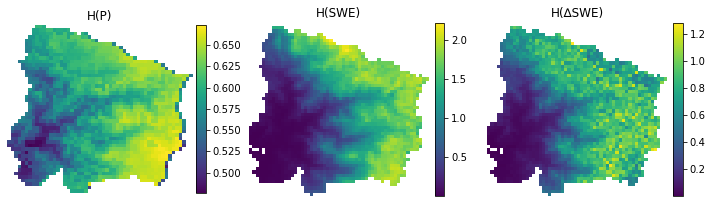

wrote ../rasters/InfoTheory_NBins/TRM_p_ent.tif
wrote ../rasters/InfoTheory_NBins/TRM_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/TRM_dswe_ent.tif


  0%|          | 0/2544 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 2544/2544 [11:45<00:00,  3.61it/s]


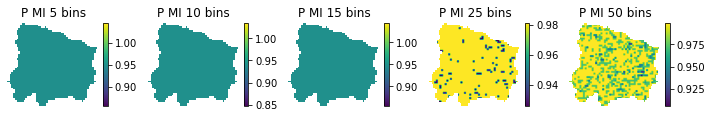

  0%|          | 0/2097 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 2097/2097 [09:59<00:00,  3.50it/s]


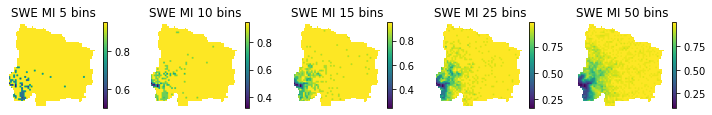

  0%|          | 0/2097 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 2097/2097 [10:11<00:00,  3.43it/s]


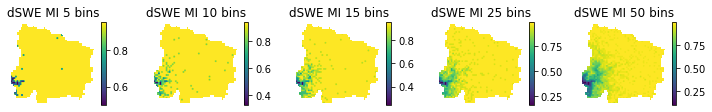

************************************************************
Processing res_id: SCC, in catchment: TULE R


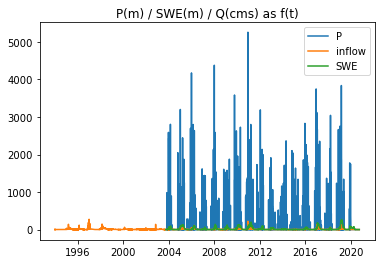

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


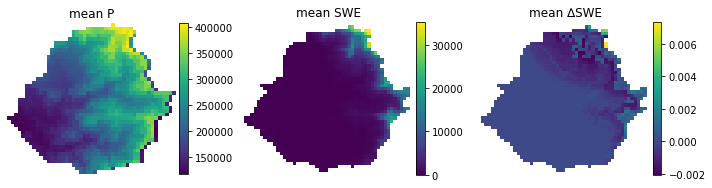

  0%|          | 9/1974 [00:00<00:23, 84.64it/s]

Bins = 27


100%|██████████| 1456/1456 [00:16<00:00, 89.70it/s]


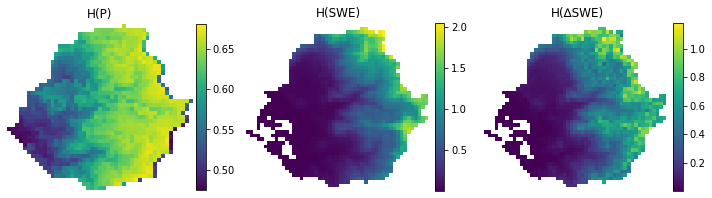

wrote ../rasters/InfoTheory_NBins/SCC_p_ent.tif
wrote ../rasters/InfoTheory_NBins/SCC_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/SCC_dswe_ent.tif


  0%|          | 0/1974 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 1974/1974 [09:33<00:00,  3.44it/s]


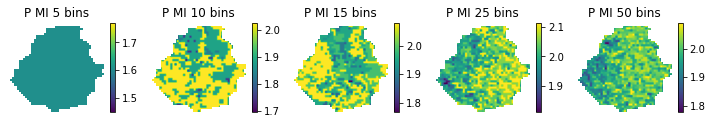

  0%|          | 0/1456 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 1456/1456 [06:49<00:00,  3.56it/s]


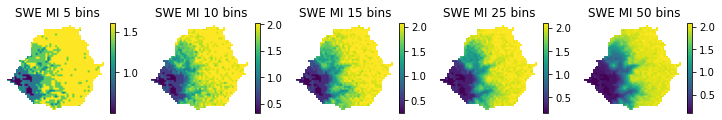

  0%|          | 0/1456 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 1456/1456 [06:41<00:00,  3.62it/s]


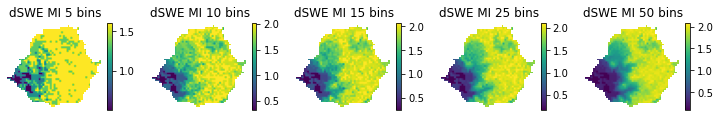

************************************************************
Processing res_id: CFW, in catchment: BEAR R
no data for CFW
************************************************************
Processing res_id: PNF, in catchment: KINGS R


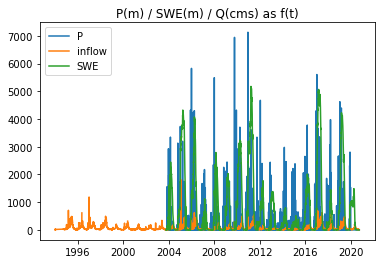

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


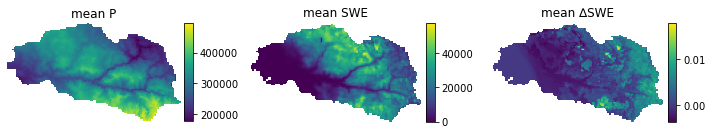

  0%|          | 9/8160 [00:00<01:31, 89.25it/s]

Bins = 27


100%|██████████| 5807/5807 [01:01<00:00, 94.11it/s]


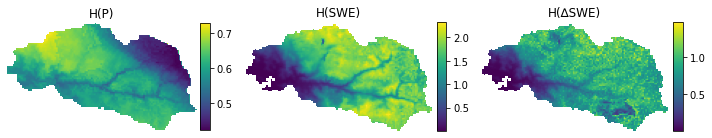

wrote ../rasters/InfoTheory_NBins/PNF_p_ent.tif
wrote ../rasters/InfoTheory_NBins/PNF_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/PNF_dswe_ent.tif


  0%|          | 0/8160 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 8160/8160 [37:27<00:00,  3.63it/s]


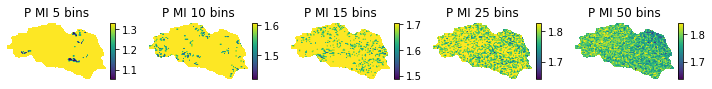

  0%|          | 0/5807 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 5807/5807 [26:43<00:00,  3.62it/s]


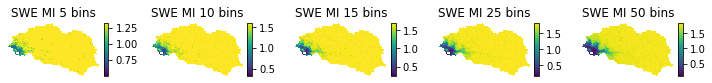

  0%|          | 0/5807 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 5807/5807 [26:54<00:00,  3.60it/s]


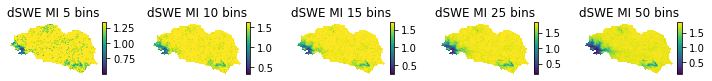

************************************************************
Processing res_id: MCR, in catchment: MERCED R
no data for MCR
************************************************************
Processing res_id: NHG, in catchment: CALAVERAS R


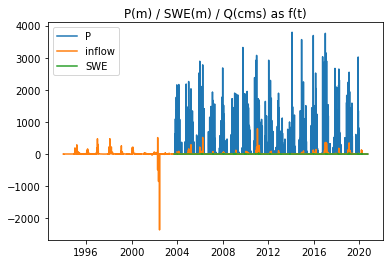

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


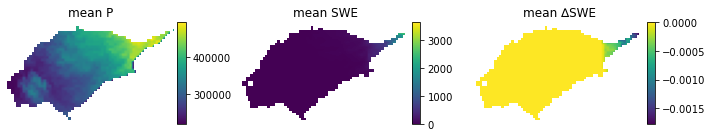

  1%|          | 19/2496 [00:00<00:27, 90.95it/s]

Bins = 27


100%|██████████| 1395/1395 [00:14<00:00, 94.39it/s]


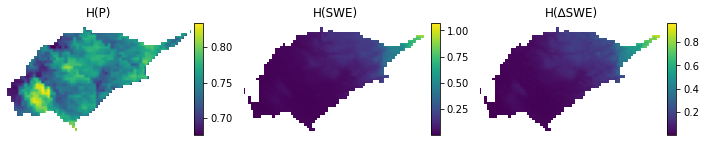

wrote ../rasters/InfoTheory_NBins/NHG_p_ent.tif
wrote ../rasters/InfoTheory_NBins/NHG_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/NHG_dswe_ent.tif


  0%|          | 0/2496 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 2496/2496 [11:27<00:00,  3.63it/s]


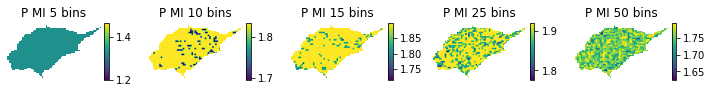

  0%|          | 0/1395 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 1395/1395 [06:26<00:00,  3.61it/s]


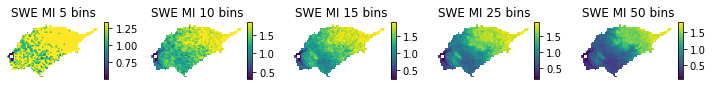

  0%|          | 0/1395 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 1395/1395 [06:26<00:00,  3.61it/s]


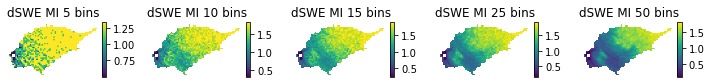

************************************************************
Processing res_id: SHA, in catchment: SACRAMENTO R


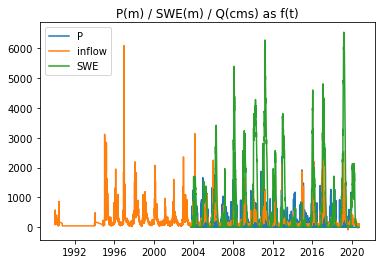

<ipython-input-5-48454458804f>:64: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


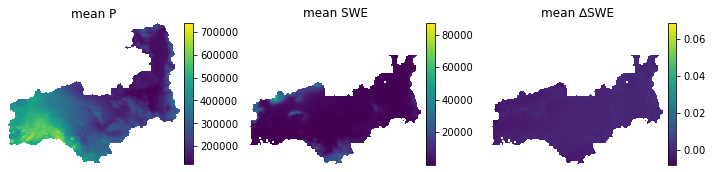

  0%|          | 8/58911 [00:00<12:22, 79.37it/s]

Bins = 27


100%|██████████| 26800/26800 [04:46<00:00, 93.41it/s]


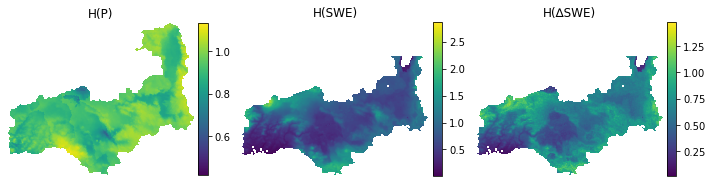

wrote ../rasters/InfoTheory_NBins/SHA_p_ent.tif
wrote ../rasters/InfoTheory_NBins/SHA_swe_ent.tif
wrote ../rasters/InfoTheory_NBins/SHA_dswe_ent.tif


  0%|          | 0/58911 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 58911/58911 [4:31:39<00:00,  3.61it/s]  


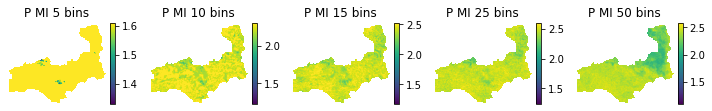

  0%|          | 0/26800 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 26800/26800 [2:03:39<00:00,  3.61it/s]  


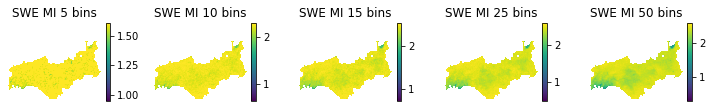

  0%|          | 0/26800 [00:00<?, ?it/s]

Bins = 27


100%|██████████| 26800/26800 [2:04:03<00:00,  3.60it/s]  


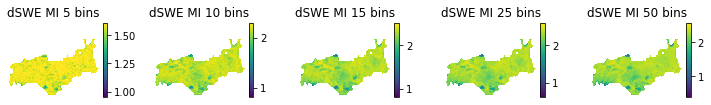

In [5]:
for idx, x in enumerate(gdf[:].iterrows()):

    print("****" * 15)
    row  = x[1]
    stn_id = row['stid']
    catch_shp = "../shape/{}.shp".format(stn_id)
    print("Processing res_id: {}, in catchment: {}".format(stn_id, row['catch_name']))

    # Set filepaths
    resfn = os.path.join('../data/res_inflow/{}_res.csv'.format(stn_id))
    swestack_fn = os.path.join('../data/swe/{}_swe.npy'.format(stn_id))
    pstack_fn = os.path.join('../data/prcp/{}_prcp.npy'.format(stn_id))
    
    # Get the daily reservoir inflow
    if not os.path.exists(resfn):
        try:
            inflow = rs.col_to_dt(get_res_data(stn_id, startdate, enddate))
            inflow.to_csv(resfn)
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(resfn))
        
    if len(inflow) == 0:
        print("no data for {}".format(stn_id))
        continue

    # Get the SWE
    if not os.path.exists(swestack_fn):
        swe = get_snodas_swe(catch_shp, startdate, enddate)
        swevals = swe.values()
        swestack = np.dstack(list(swe.values()))
        np.save(swestack_fn, swestack)
    else:
        swestack = np.load(swestack_fn)
        swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]
    
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)

    # Get the P data
    if not os.path.exists(pstack_fn):
        rsdat = rs.load_data()
        area = rs.gdf_to_ee_poly(gp.read_file(catch_shp))
        pdat = rs.get_daily_ims(rsdat['dmet'], startdate, enddate, area, return_dates = True)
        
        pstack = np.dstack(list(pdat.values()))
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        np.save(pstack_fn, pstack)
    else:
        pstack = np.load(pstack_fn)
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
    
    # Sanity check - plot time series sums
    plt.plot(pd.date_range('2003-09-30','2020-10-01', freq='D'), [np.nanmean(x)*1e2 for x in pvals], label = "P")
    plt.plot(inflow.index, inflow.q_cms, label = "inflow")
    plt.plot(pd.date_range('2003-09-30','2020-10-01', freq='D'), [np.nansum(x) for x in swevals], label = 'SWE')
    plt.title("P(m) / SWE(m) / Q(cms) as f(t)")
    plt.legend()
    plt.show()
    
    # Plot annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    pmean[pmean == 0] = np.nan
    plot_mean_ims(pmean, swemean, dswemean, stid = stn_id)
        
    # Compute pixelwise entropy
    p_ent = calc_pstack_entropy(pstack)
    p_ent[p_ent==0] = np.nan
    swe_ent = calc_swestack_entropy(swestack, dswe = False)
    swe_ent[swe_ent == 0] = np.nan
    dswe_ent = calc_swestack_entropy(dswe, dswe = True)
    dswe_ent[dswe_ent == 0] = np.nan
    
    plot_ent_ims(p_ent,swe_ent,dswe_ent, stid = stn_id)

    # Setup write dir
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    # Write 
    p_ent_fn = os.path.join(outdir,"{}_p_ent.tif".format(stn_id))
    swe_ent_fn = os.path.join(outdir,"{}_swe_ent.tif".format(stn_id))
    dswe_ent_fn = os.path.join(outdir,"{}_dswe_ent.tif".format(stn_id))

    for im, fn in zip([p_ent, swe_ent, dswe_ent], [p_ent_fn, swe_ent_fn, dswe_ent_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
    
    # Precip
    p_mi5_im, p_mi10_im, p_mi15_im, p_mi25_im, p_mi50_im = calc_mi_bins(pstack, dswe =False, inflow = inflow)

    p_mi5_im = np.ma.masked_array(p_mi5_im, mask=np.isnan(pmean))
    p_mi10_im =np.ma.masked_array(p_mi10_im, mask=np.isnan(pmean))
    p_mi15_im =np.ma.masked_array(p_mi15_im, mask=np.isnan(pmean))
    p_mi25_im =np.ma.masked_array(p_mi25_im, mask=np.isnan(pmean))
    p_mi50_im =np.ma.masked_array(p_mi50_im, mask=np.isnan(pmean))

    plot_mi_bins_ims(p_mi5_im, p_mi10_im, p_mi15_im, p_mi25_im, p_mi50_im, stid = stn_id,var = "P")

    # SWE
    swe_mi5_im, swe_mi10_im, swe_mi15_im, swe_mi25_im, swe_mi50_im = calc_mi_bins(swestack, dswe =False, inflow = inflow)
    
    swe_mi5_im = np.ma.masked_array(swe_mi5_im, mask=np.isnan(swemean))
    swe_mi10_im =np.ma.masked_array(swe_mi10_im, mask=np.isnan(swemean))
    swe_mi15_im =np.ma.masked_array(swe_mi15_im, mask=np.isnan(swemean))
    swe_mi25_im =np.ma.masked_array(swe_mi25_im, mask=np.isnan(swemean))
    swe_mi50_im =np.ma.masked_array(swe_mi50_im, mask=np.isnan(swemean))
    
    plot_mi_bins_ims(swe_mi5_im, swe_mi10_im, swe_mi15_im, swe_mi25_im, swe_mi50_im, stid = stn_id,var = "SWE")
    
    # dswe
    dswe_mi5_im, dswe_mi10_im, dswe_mi15_im, dswe_mi25_im, dswe_mi50_im = calc_mi_bins(dswe, dswe =True, inflow = inflow)
    
    dswe_mi5_im = np.ma.masked_array(dswe_mi5_im, mask=np.isnan(dswemean))
    dswe_mi10_im =np.ma.masked_array(dswe_mi10_im, mask=np.isnan(dswemean))
    dswe_mi15_im =np.ma.masked_array(dswe_mi15_im, mask=np.isnan(dswemean))
    dswe_mi25_im =np.ma.masked_array(dswe_mi25_im, mask=np.isnan(dswemean))
    dswe_mi50_im =np.ma.masked_array(dswe_mi50_im, mask=np.isnan(dswemean))
    
    plot_mi_bins_ims(dswe_mi5_im, dswe_mi10_im, dswe_mi15_im, dswe_mi25_im, dswe_mi50_im, stid = stn_id,var = "dSWE")